In [1]:
import gpr

import numpy as np
import gpflow
import tensorflow as tf
import astropy.io.fits as pf
import matplotlib.pyplot as plt

W0715 11:32:56.264390 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0715 11:32:56.266131 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0715 11:32:56.305134 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/saver/coders.py:80: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.



In [2]:
class EBF(gpflow.kernels.Kernel):
    def __init__(self, input_dim, var_s=1., sigma_x=1., sigma_y=1., phi=0., active_dims=None):
        super().__init__(input_dim=input_dim, active_dims=active_dims)
        self.var_s = gpflow.Param(var_s, transform=gpflow.transforms.positive)
        self.sigma_x = gpflow.Param(sigma_x, transform=gpflow.transforms.positive)
        self.sigma_y = gpflow.Param(sigma_x, transform=gpflow.transforms.positive)
        self.phi = gpflow.Param(phi)
    
    @gpflow.params_as_tensors
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
            
        self.u1, self.u2 = X[:, 0], X2[:, 0]
        self.v1, self.v2 = X[:, 1], X2[:, 1]
        
        self.uu1, self.uu2 = tf.meshgrid(self.u1, self.u2)
        self.vv1, self.vv2 = tf.meshgrid(self.v1, self.v2)
        
        self.a = tf.cos(self.phi)**2. / (2. * self.sigma_x**2.) + tf.sin(self.phi)**2. / (2. * self.sigma_y**2.)
        self.b = - tf.sin(2. * self.phi) / (4. * self.sigma_x**2.) + tf.sin(2. * self.phi) / (4. * self.sigma_y**2.)
        self.c = tf.sin(self.phi)**2. / (2. * self.sigma_x**2.) + tf.cos(self.phi)**2. / (2. * self.sigma_y**2.)

        self.uu = self.a * (self.uu1 - self.uu2)**2
        self.vv = self.c * (self.vv1 - self.vv2)**2
        self.uv = 2. * self.b * (self.uu1 - self.uu2)*(self.vv1 - self.vv2)
        
        return self.var_s * tf.reshape(tf.exp(-(self.uu + self.vv + self.uv)), (tf.shape(X)[0], tf.shape(X2)[0]))
    
    @gpflow.params_as_tensors
    def Kdiag(self, X):
        return self.var_s * tf.cast(tf.ones(tf.shape(X)[0]), tf.float64)

In [3]:
class ShotNoise(gpflow.kernels.Static):
    def __init__(self, input_dim, shot_noise_train, shot_noise_test, active_dims=None, name=None):
        super().__init__(input_dim=input_dim, active_dims=active_dims, name=name)
        self.shot_noise_train = shot_noise_train
        self.shot_noise_test = shot_noise_test
    
    @gpflow.params_as_tensors
    def K(self, X, X2=None):
        if X2 is not None:
            X2 = X
            return tf.linalg.diag(self.shot_noise_test)
        return tf.linalg.diag(self.shot_noise_train)
    
    @gpflow.params_as_tensors
    def Kdiag(self, X):
        return self.shot_noise_train

In [4]:
GP = gpr.GPR(verbose=True, random_state=0)

In [5]:
thetaS = np.array([250, 0.6, 0.08, np.pi/3])
GP.gen_synthetic_data(5000, thetaS)
# GP.extract_exposure()

Generating synthetic data...


In [6]:
# sample = np.array([-0.5, 0, 0, 0.5])
# sample = None
# GP.extract_data(sample=sample)

Removing data points that have residuals greater than 2 standard deviations from the mean...


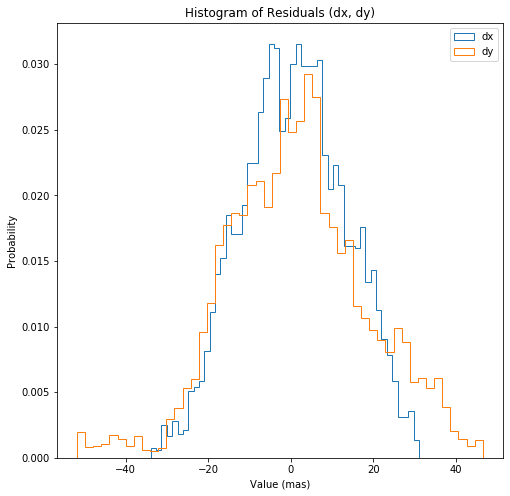

91.54% (4577) data points are being kept.


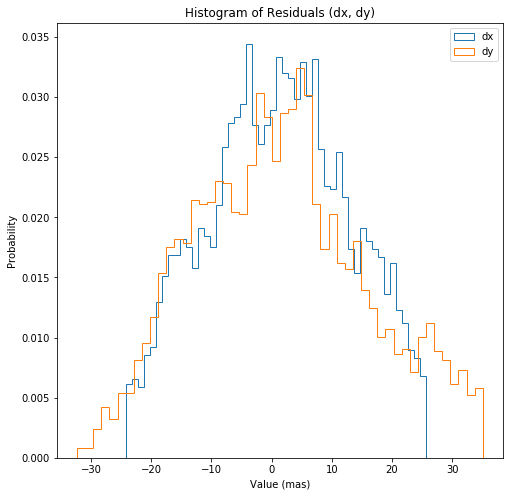

Splitting data into training and testing sets...
Generating white noise covariance function...


In [7]:
GP.remove_outliers(2)
GP.split_data(0.20)
GP.white_cov()

Generating elliptical covariance function...
Solving for posterior...
Posterior solved for in 1.620288372039795 seconds.
Current Log Marginal Likelihood: 700.6357973417239
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.9814410480349345; dy: 0.9847161572052402
Chisq dx: 0.771004732528817; Chisq dy: 0.8416993692160891


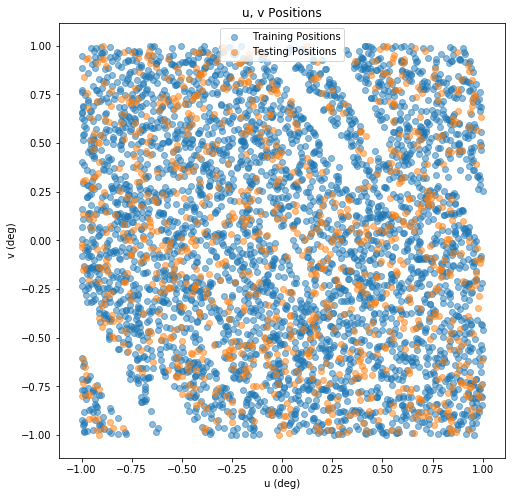

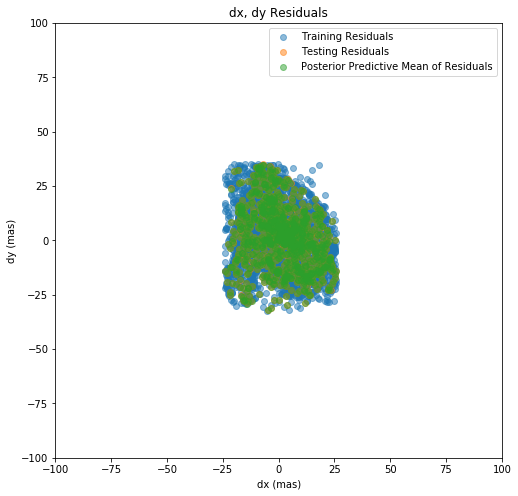

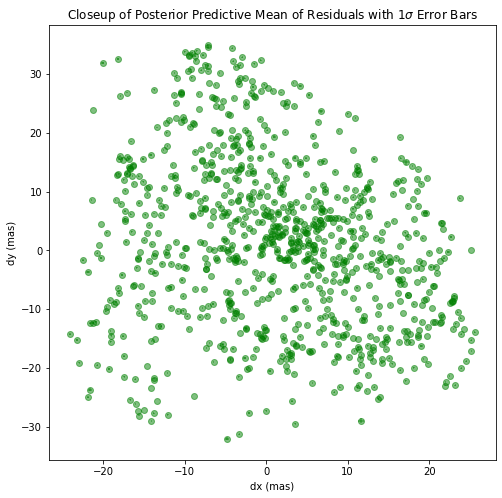

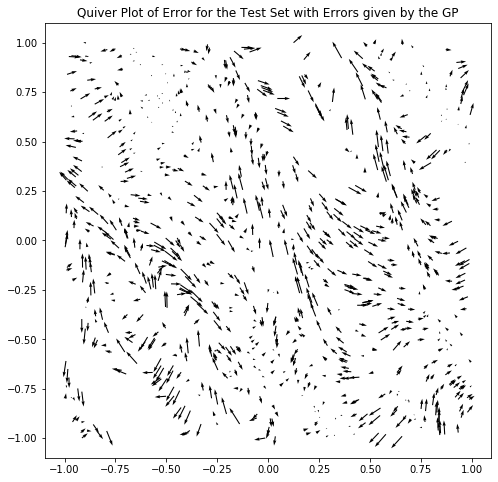

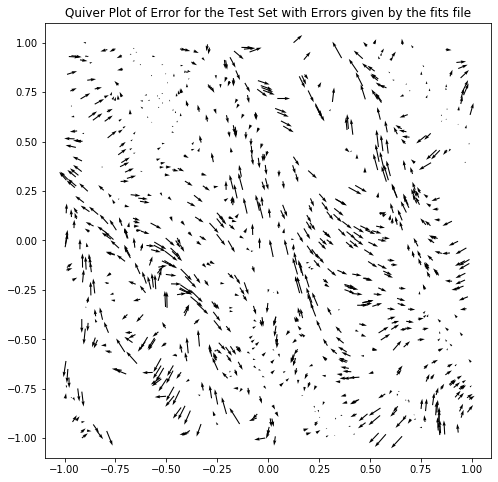

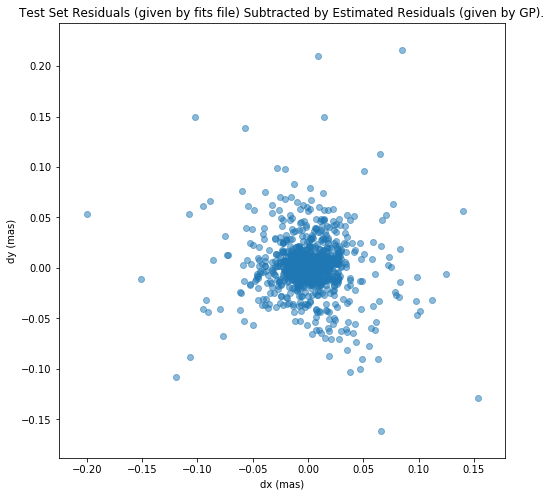

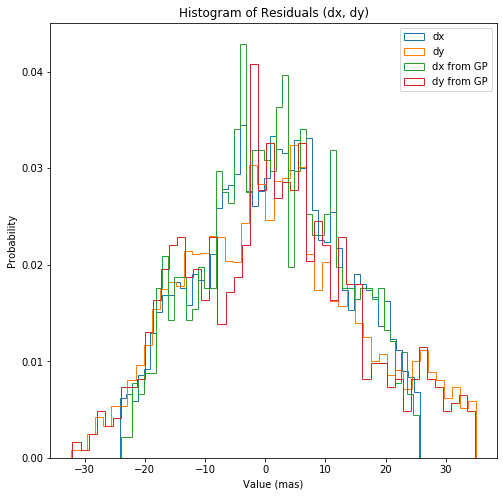

In [8]:
GP.fit(thetaS)
GP.summary()

In [9]:
kernel = EBF(2)

W0715 11:33:14.903538 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 11:33:14.921961 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 11:33:14.924106 140155395970880 deprecation_wrapper.py:119] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:394: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



In [10]:
# kernel = ShotNoise(2, GP.Etrain, GP.Etest)

In [11]:
model = gpflow.models.GPR(
    X=GP.Xtrain,
    Y=GP.Ytrain,
    kern=kernel,
    mean_function=None)

model.kern.var_s = thetaS[0]
model.kern.sigma_x = thetaS[1]
model.kern.sigma_y = thetaS[2]
model.kern.phi = thetaS[3]
model.likelihood.variance = thetaS[0]

model

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/phi,Parameter,None,(none),True,(),True,1.0471975511965976
GPR/kern/sigma_x,Parameter,None,+ve,True,(),True,0.6
GPR/kern/sigma_y,Parameter,None,+ve,True,(),True,0.08
GPR/kern/var_s,Parameter,None,+ve,True,(),True,250.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,250.0


In [12]:
optimizer = gpflow.train.ScipyOptimizer()
optimizer.minimize(model)
model

W0715 11:33:15.531238 140155395970880 deprecation.py:323] From /home/austinfortino/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/phi,Parameter,None,(none),True,(),True,1.0470195635612078
GPR/kern/sigma_x,Parameter,None,+ve,True,(),True,0.6053507231147124
GPR/kern/sigma_y,Parameter,None,+ve,True,(),True,0.0804992438223068
GPR/kern/var_s,Parameter,None,+ve,True,(),True,250.1134586064058
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000000968114477e-06


In [13]:
mean, var = model.predict_f(GP.Xtest)

In [16]:
GP.fbar_s = mean
GP.sigma = np.sqrt(np.abs(var))[:, 0]
GP.nLML = 0

Current Log Marginal Likelihood: 0
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 1.0; dy: 1.0
Chisq dx: 54725193365997.05; Chisq dy: 55624905220054.78


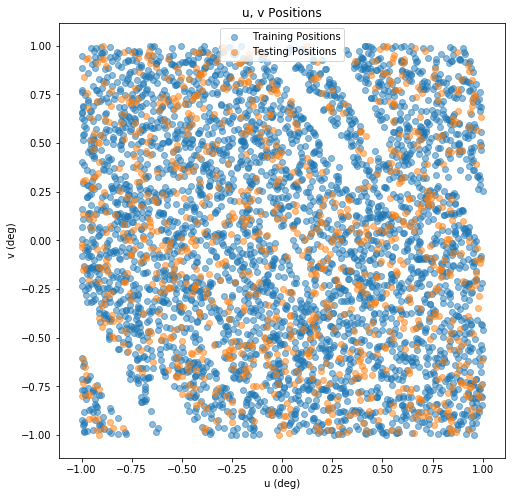

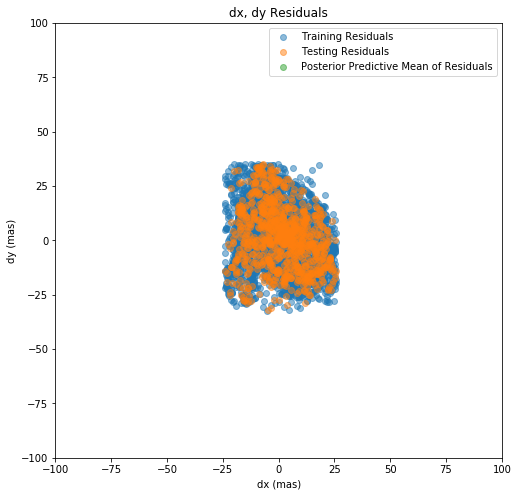

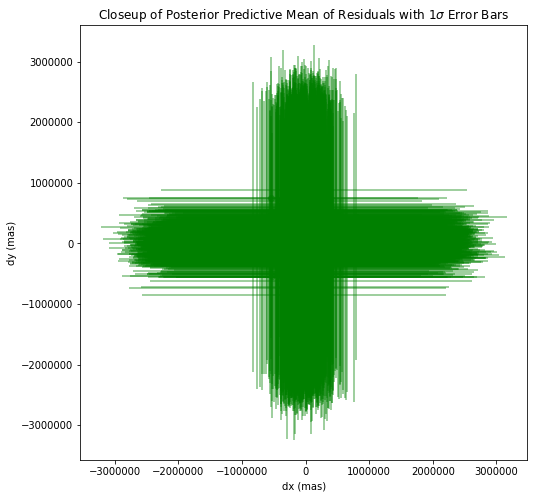

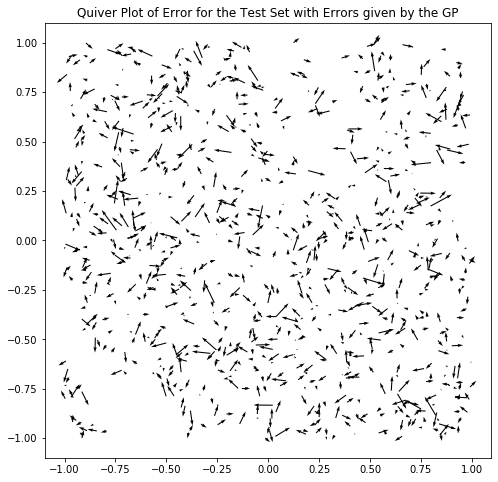

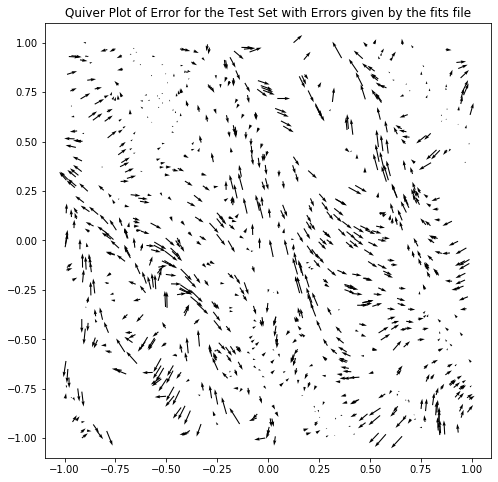

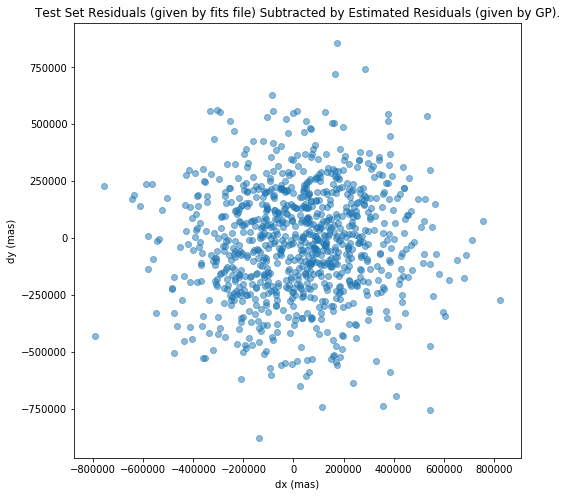

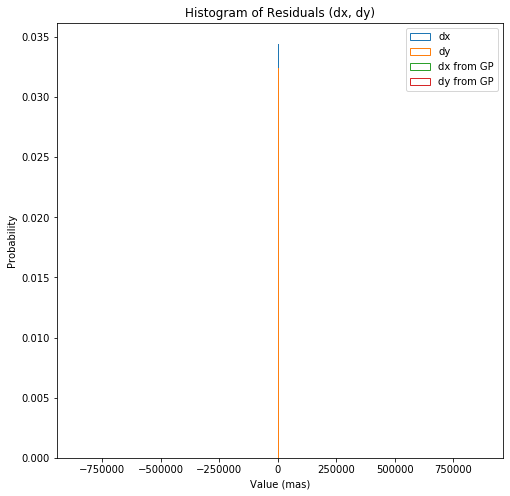

In [17]:
GP.summary()